# Прогнозирование оттока клиентов банка

У «Бета-Банка» наблюдается ежемесячный прирост оттока клиентов. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно построить модель, которая спрогнозирует, уйдёт ли клиент из банка в ближайшее время или нет, чтобы попробовать его удержать. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Нужно построить модель с предельно большим значением F1-меры, не менее 0.59

## Шаг 1. Общий обзор данных

In [238]:
import pandas as pd #подключаем необходимые библиотеки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import phik

In [ ]:
try:
    df = pd.read_csv("D:\datasets\Churn.csv", sep = ',', index_col='RowNumber') #записываем данные из файла в переменную df
except:
    df = pd.read_csv('/datasets/Churn.csv', sep = ',', index_col='RowNumber') #записываем данные из файла в переменную df

In [239]:
df.info()# общая информация о датасете

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [240]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


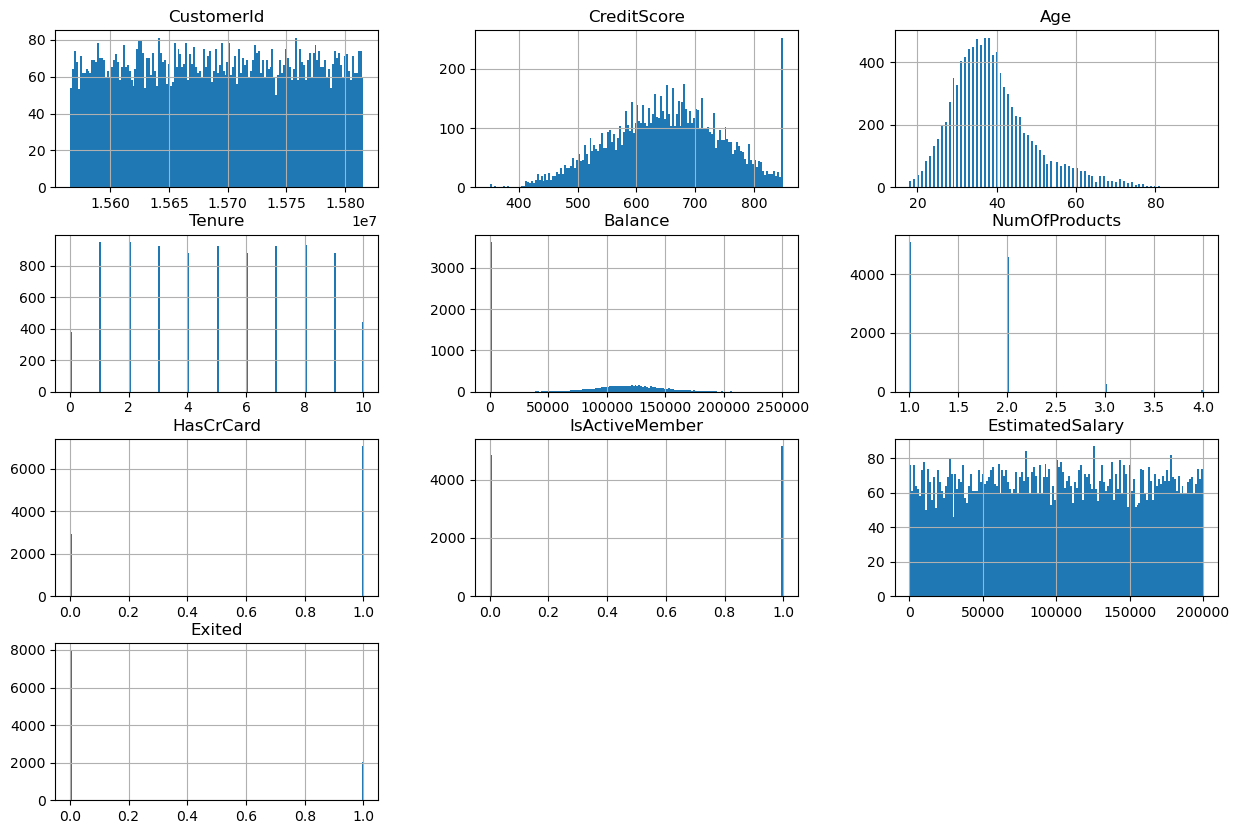

In [241]:
df.hist(bins=150, figsize=(15,10));

На графиках выше можно наблюдать дисбаланс классов:<br>Количество клиентов, которые пользуются одним или двумя продуктами банка, почти равно - 3 и 4 существенно меньше(NumOfProducts)<br>Пользователей кредитной карты банка почти в два раза больше, чем клиентов без нее(HasCrCard)<br>Пользователей, которые перестали пользоваться услугами банка, в 4 раза меньше.

In [242]:
df.pivot_table(index=['Exited'], values=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'])# сводная таблица по целевому признаку

,Age,Balance,CreditScore,EstimatedSalary,HasCrCard,IsActiveMember,NumOfProducts,Tenure
Exited,,,,,,,,
0,37.408389,72745.296779,651.853196,99738.391772,0.707146,0.554565,1.544267,5.022247
1,44.837997,91108.539337,645.351497,101465.677531,0.699067,0.360825,1.475209,4.901834


Клиенты, которые перестали пользоваться услугами банка, в среднем на 7 с половиной лет старше и имели на 20 тысяч больше на балансе. По остальным средним значениям признаков сложно что-либо сказать

In [243]:
df.phik_matrix().round(2)# матрица корреляций

interval columns not set, guessing: ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


C:\anaconda\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Surname is large: 2932. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  warnings.warn(


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,1.00,0.00,0.02,0.00,0.00,0.04,0.01,0.00,0.01,0.00,0.01,0.00,0.03
Surname,0.00,1.00,0.24,0.00,0.04,0.33,0.02,0.48,0.20,0.00,0.00,0.08,0.00
CreditScore,0.02,0.24,1.00,0.04,0.00,0.00,0.00,0.00,0.03,0.00,0.04,0.03,0.10
Geography,0.00,0.00,0.04,1.00,0.01,0.09,0.00,0.46,0.05,0.00,0.01,0.03,0.10
Gender,0.00,0.04,0.00,0.01,1.00,0.03,0.03,0.00,0.06,0.00,0.03,0.03,0.17
Age,0.04,0.33,0.00,0.09,0.03,1.00,0.05,0.04,0.15,0.02,0.19,0.05,0.49
Tenure,0.01,0.02,0.00,0.00,0.03,0.05,1.00,0.06,0.06,0.03,0.03,0.00,0.02
Balance,0.00,0.48,0.00,0.46,0.00,0.04,0.06,1.00,0.37,0.05,0.02,0.00,0.18
NumOfProducts,0.01,0.20,0.03,0.05,0.06,0.15,0.06,0.37,1.00,0.00,0.06,0.03,0.57
HasCrCard,0.00,0.00,0.00,0.00,0.00,0.02,0.03,0.05,0.00,1.00,0.01,0.00,0.00


Наблюдается средняя корреляция между признаком столбца Exited и количеством банковских продуктов пользователя


## Шаг 2. Подготовка данных(без учета баланса классов)

In [244]:
df.isna().sum()# смотрим пропущенные значения

CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Так как столбец Tenure не имеет корреляции с другими параметрами выборки, можно заменить пропущенные значения средним. Удалять почти 10% данных может слишком сильно отразиться на качестве модели.

In [245]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [246]:
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Для начала выделим признаки для обучения модели. Целевой признак - столбец 'Exited'. В качестве признаков берем все столбцы, кроме CustomerId и Surname - эти данные нужны для идентификации клиента и не помогут в обучении модели.

In [247]:
features = df.drop(['CustomerId', 'Surname', 'Exited'], axis=1)
target = df['Exited']

Преобразуем категориальные признаки в численные с помощью OHE, избегаем дамми-ловушку

In [248]:
features = pd.get_dummies(data=features, columns=['Geography', 'Gender'], drop_first=True)

Теперь разделим весь датасет на выборки - обучающую валидационную и тестовую в соотношении 3:1:1

In [249]:
features_train, features_other, target_train, target_other = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)# для начала выделим обучающую выборку с учетом дисбаланса
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other, test_size=0.5, random_state=12345, stratify=target_other)# разделим 40% датасета на валидационную и тестовую выборки с учетом дисбаланса

In [250]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


Масштабируем количественные признаки, чтобы их сбалансировать

In [251]:
scaler = StandardScaler()
columns_to_scale = ['CreditScore', 'Balance', 'EstimatedSalary','Age','Tenure']
features_train[columns_to_scale] = scaler.fit_transform(features_train[columns_to_scale])# настраиваем и масштабируем количественные переменные тренировочной выборки
features_valid[columns_to_scale] = scaler.fit_transform(features_valid[columns_to_scale])# настраиваем и масштабируем количественные переменные валидационной выборки
features_test[columns_to_scale] = scaler.fit_transform(features_test[columns_to_scale])# настраиваем и масштабируем количественные переменные тестовой выборки

## Шаг 3. Выбор модели(без учета баланса)

Выбирать будем из трех моделей обучения - решающее дерево, случайный лес и логистическая регрессия. В каждой модели возьмем лучший набор гиперпараметров и проверим на валидационной выборке

### Решающее дерево

В данной модели нужно проверить разные значения гиперпараметра max_depth на метрику F1 по валидационной выборке


In [252]:
%%time
best_model_tree = None# в переменной сохранится лучшая модель после проверки
best_f1 = 0
best_f1_train = 0
best_depth = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 300):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)# инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions_valid = model.predict(features_valid)# получаем предсказания модели на валидационной выборке
    predictions_train = model.predict(features_train)# получаем предсказания модели на тестовой выборке
    f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
    f1_train = f1_score(target_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
    f1_change_train.append(f1_train)
    f1_change_valid.append(f1_valid)
    if best_f1 < f1_valid:
        best_model_tree = model
        best_f1 = f1_valid
        best_f1_train = f1_train
        best_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_f1,"F1 наилучшей модели на обучающей выборке:", best_f1_train,"Глубина дерева:", best_depth)

F1 наилучшей модели на валидационной выборке: 0.5950653120464441 F1 наилучшей модели на обучающей выборке: 0.6115288220551378 Глубина дерева: 7
Wall time: 10 s


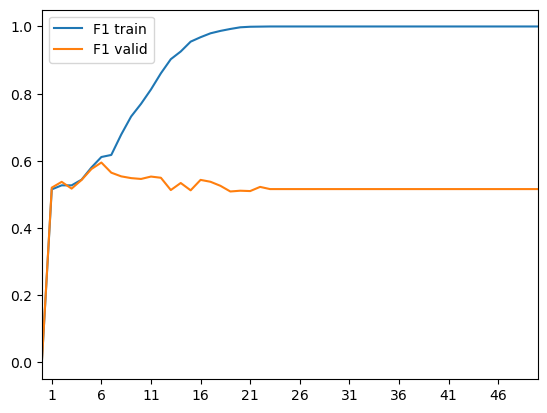

In [253]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 50])
plt.legend()
plt.show()

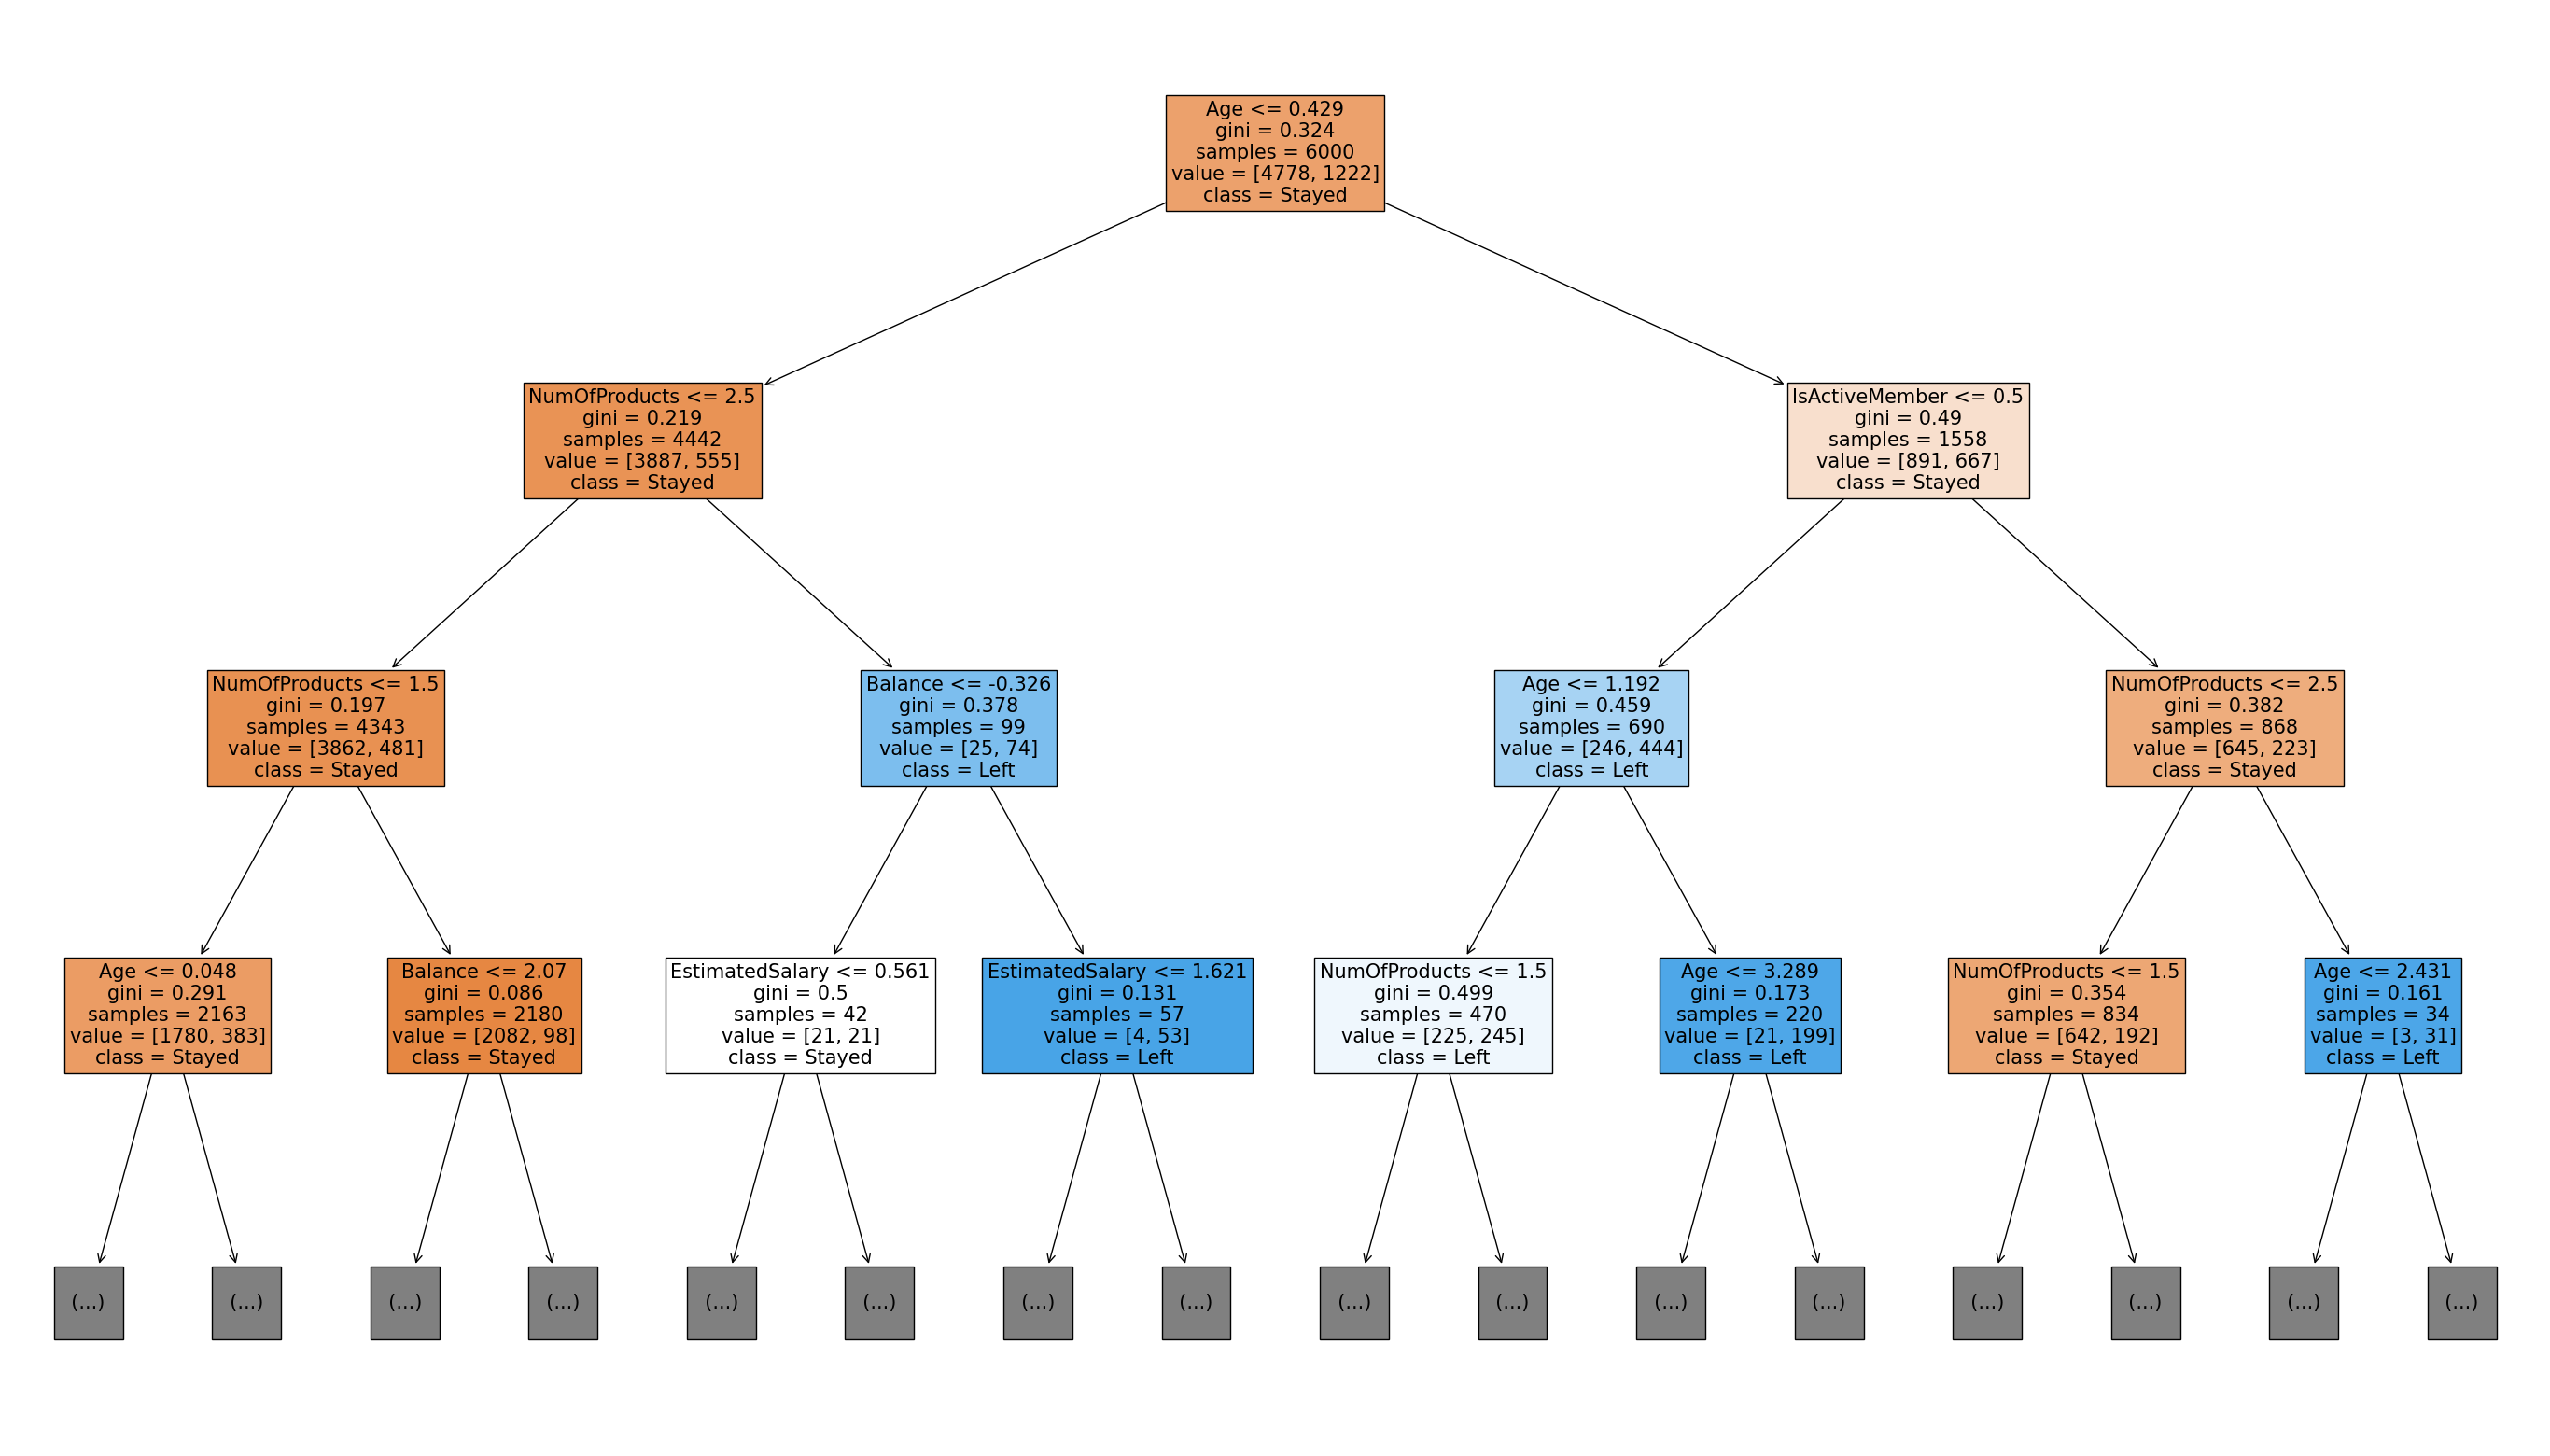

In [254]:
fig = plt.figure(figsize=(35,20))# график, который показывает, как модель делает предсказания
tree.plot_tree(best_model_tree,
                   feature_names=features.columns.values,
                   class_names=['Stayed','Left'],
                   filled=True,
                   fontsize = 15,
                   max_depth = 3
                   )
plt.show()

После лучшего значения F1 на валидационной выборке F1 на тренировочной стремится к 1 - следствие заучивания ответов моделью

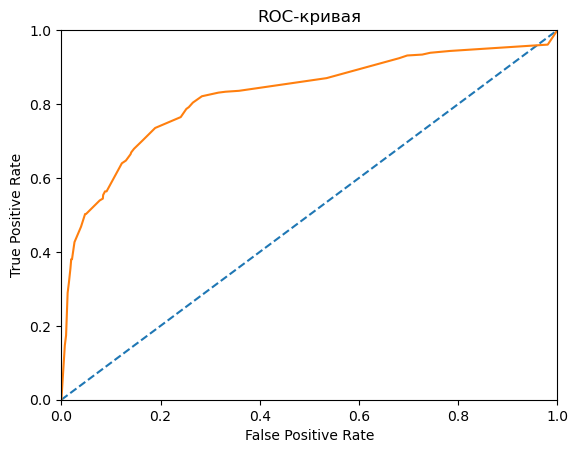

In [255]:
probabilities_valid = best_model_tree.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модель с высоким качеством получается, если TPR - около 0.8, а FPR - чуть больше 0.2

In [256]:
roc_auc_score(target_valid, probabilities_one_valid)# метрика AUC-ROC

0.8235694403389496

Метрика AUC-ROC показывает, что модель предсказывает целевой признак лучше, чем случайная модель

### Случайный лес

В данной модели нужно проверить разные значения гиперпараметра max_depth и n_estimators на F1 в валидационной выборке

In [257]:
%%time
best_model_forest = None# в переменной сохранится лучшая модель после проверки
best_f1 = 0
best_f1_train = 0
best_depth = 0
best_est = 0
f1_change_train = []
f1_change_valid = []
for est in range(10, 120, 6):
    for depth in range(1, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)# инициализируйте модель RandomForestClassifier с параметрами random_state=12345, n_estimators=est и max_depth=depth
        model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
        predictions_valid = model.predict(features_valid)# получаем предсказания модели на валидационной выборке
        predictions_train = model.predict(features_train)# получаем предсказания модели на тестовой выборке
        f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
        f1_train = f1_score(target_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
        f1_change_train.append(f1_train)
        f1_change_valid.append(f1_valid)
        if best_f1 < f1_valid:
            best_model_forest = model
            best_f1 = f1_valid
            best_f1_train = f1_train
            best_depth = depth
            best_est = est
print("F1 наилучшей модели на валидационной выборке:", best_f1,"F1 наилучшей модели на обучающей выборке:", best_f1_train,"Количество деревьев:", best_est, "Глубина дерева:", best_depth)

F1 наилучшей модели на валидационной выборке: 0.6262924667651404 F1 наилучшей модели на обучающей выборке: 0.9462827675118178 Количество деревьев: 46 Глубина дерева: 15
Wall time: 1min 41s


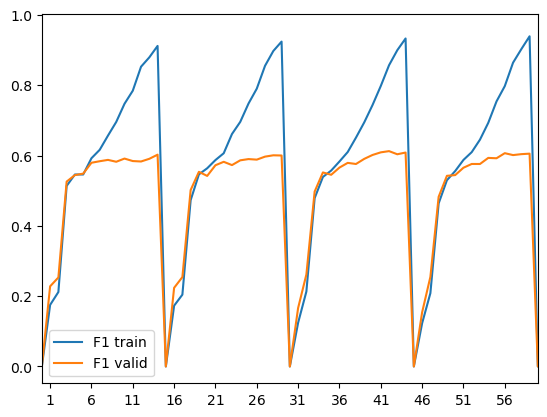

In [258]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины и количества деревьев
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 60])
plt.legend()
plt.show()

Случайный лес показывает почти 100% заучивание на тренировочной выборке при наивысшем показателе F1 на валидационной выборке

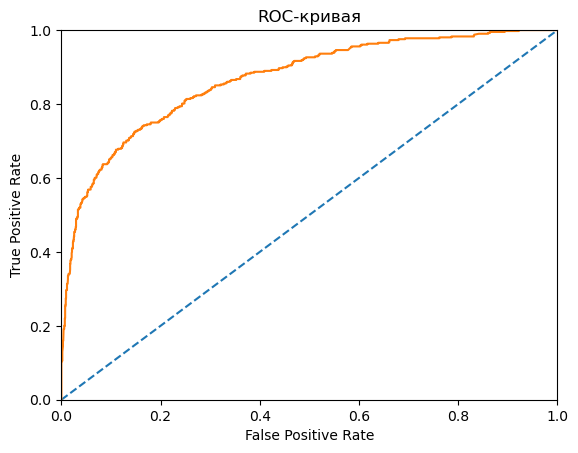

In [259]:
probabilities_valid = best_model_forest.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Модель с высоким качеством получается, если TPR - около 0.8, а FPR - чуть больше 0.2

In [260]:
roc_auc_score(target_valid, probabilities_one_valid)# метрика AUC-ROC

0.8671813417578087

Метрика AUC-ROC показывает, что модель предсказывает целевой признак лучше, чем случайная модель, показатель выше, чем у дерева решений

### Логистическая регрессия


In [261]:
model_regression = LogisticRegression(random_state=12345)# инициализируем модель LogisticRegression
model_regression.fit(features_train, target_train)
predictions_valid = model_regression.predict(features_valid)
predictions_train = model_regression.predict(features_train)
f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
f1_train = f1_score(target_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
print("F1 наилучшей модели на валидационной выборке:", f1_valid,"F1 наилучшей модели на обучающей выборке:", f1_train)

F1 наилучшей модели на валидационной выборке: 0.3107861060329068 F1 наилучшей модели на обучающей выборке: 0.3190332326283987


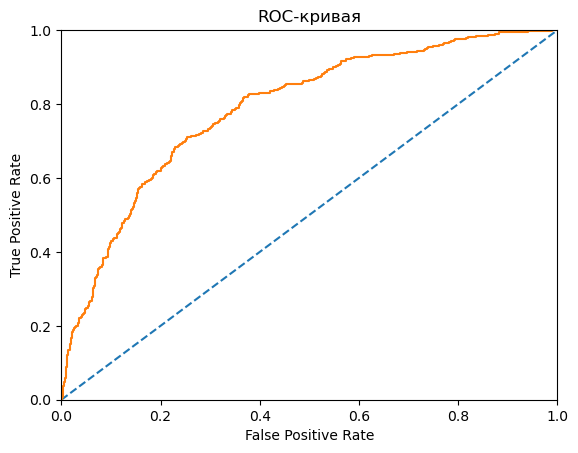

In [262]:
probabilities_valid = model_regression.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [263]:
roc_auc_score(target_valid, probabilities_one_valid)  # метрика AUC-ROC

0.78760684550202

Качество модели логистической регрессии явно ниже, чем у леса и дерева

Не учитывая дисбаланс классов мы получили достаточно неплохой результат у модели случайный лес: F1 - 0.63(модель правильно классифицирует 63% всех положительных и отрицательных примеров), AUC-ROC - 0.86(модель предсказывает намного лучше случайной)<br>Попробуем устранить дисбаланс классов и улучшить модель

## Шаг 4. Выбор модели(с учетом баланса)

### Вес классов сбалансируем с помощью аргумента class_weight='balanced'

#### Решающее дерево

In [264]:
%%time
best_model_tree_scaled = None# в переменной сохранится лучшая модель после проверки
best_f1 = 0
best_f1_train = 0
best_depth = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 300):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')# инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions_valid = model.predict(features_valid)# получаем предсказания модели на валидационной выборке
    predictions_train = model.predict(features_train)# получаем предсказания модели на тестовой выборке
    f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
    f1_train = f1_score(target_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
    f1_change_train.append(f1_train)
    f1_change_valid.append(f1_valid)
    if best_f1 < f1_valid:
        best_model_tree_scaled = model
        best_f1 = f1_valid
        best_f1_train = f1_train
        best_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_f1,"F1 наилучшей модели на обучающей выборке:", best_f1_train,"Глубина дерева:", best_depth)

F1 наилучшей модели на валидационной выборке: 0.5764596848934197 F1 наилучшей модели на обучающей выборке: 0.6022623051054724 Глубина дерева: 6
Wall time: 10.8 s


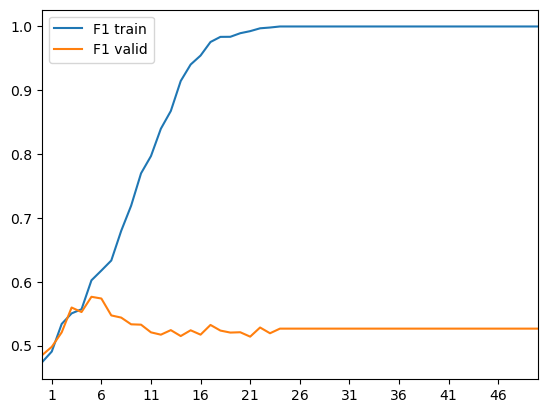

In [265]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 50])
plt.legend()
plt.show()

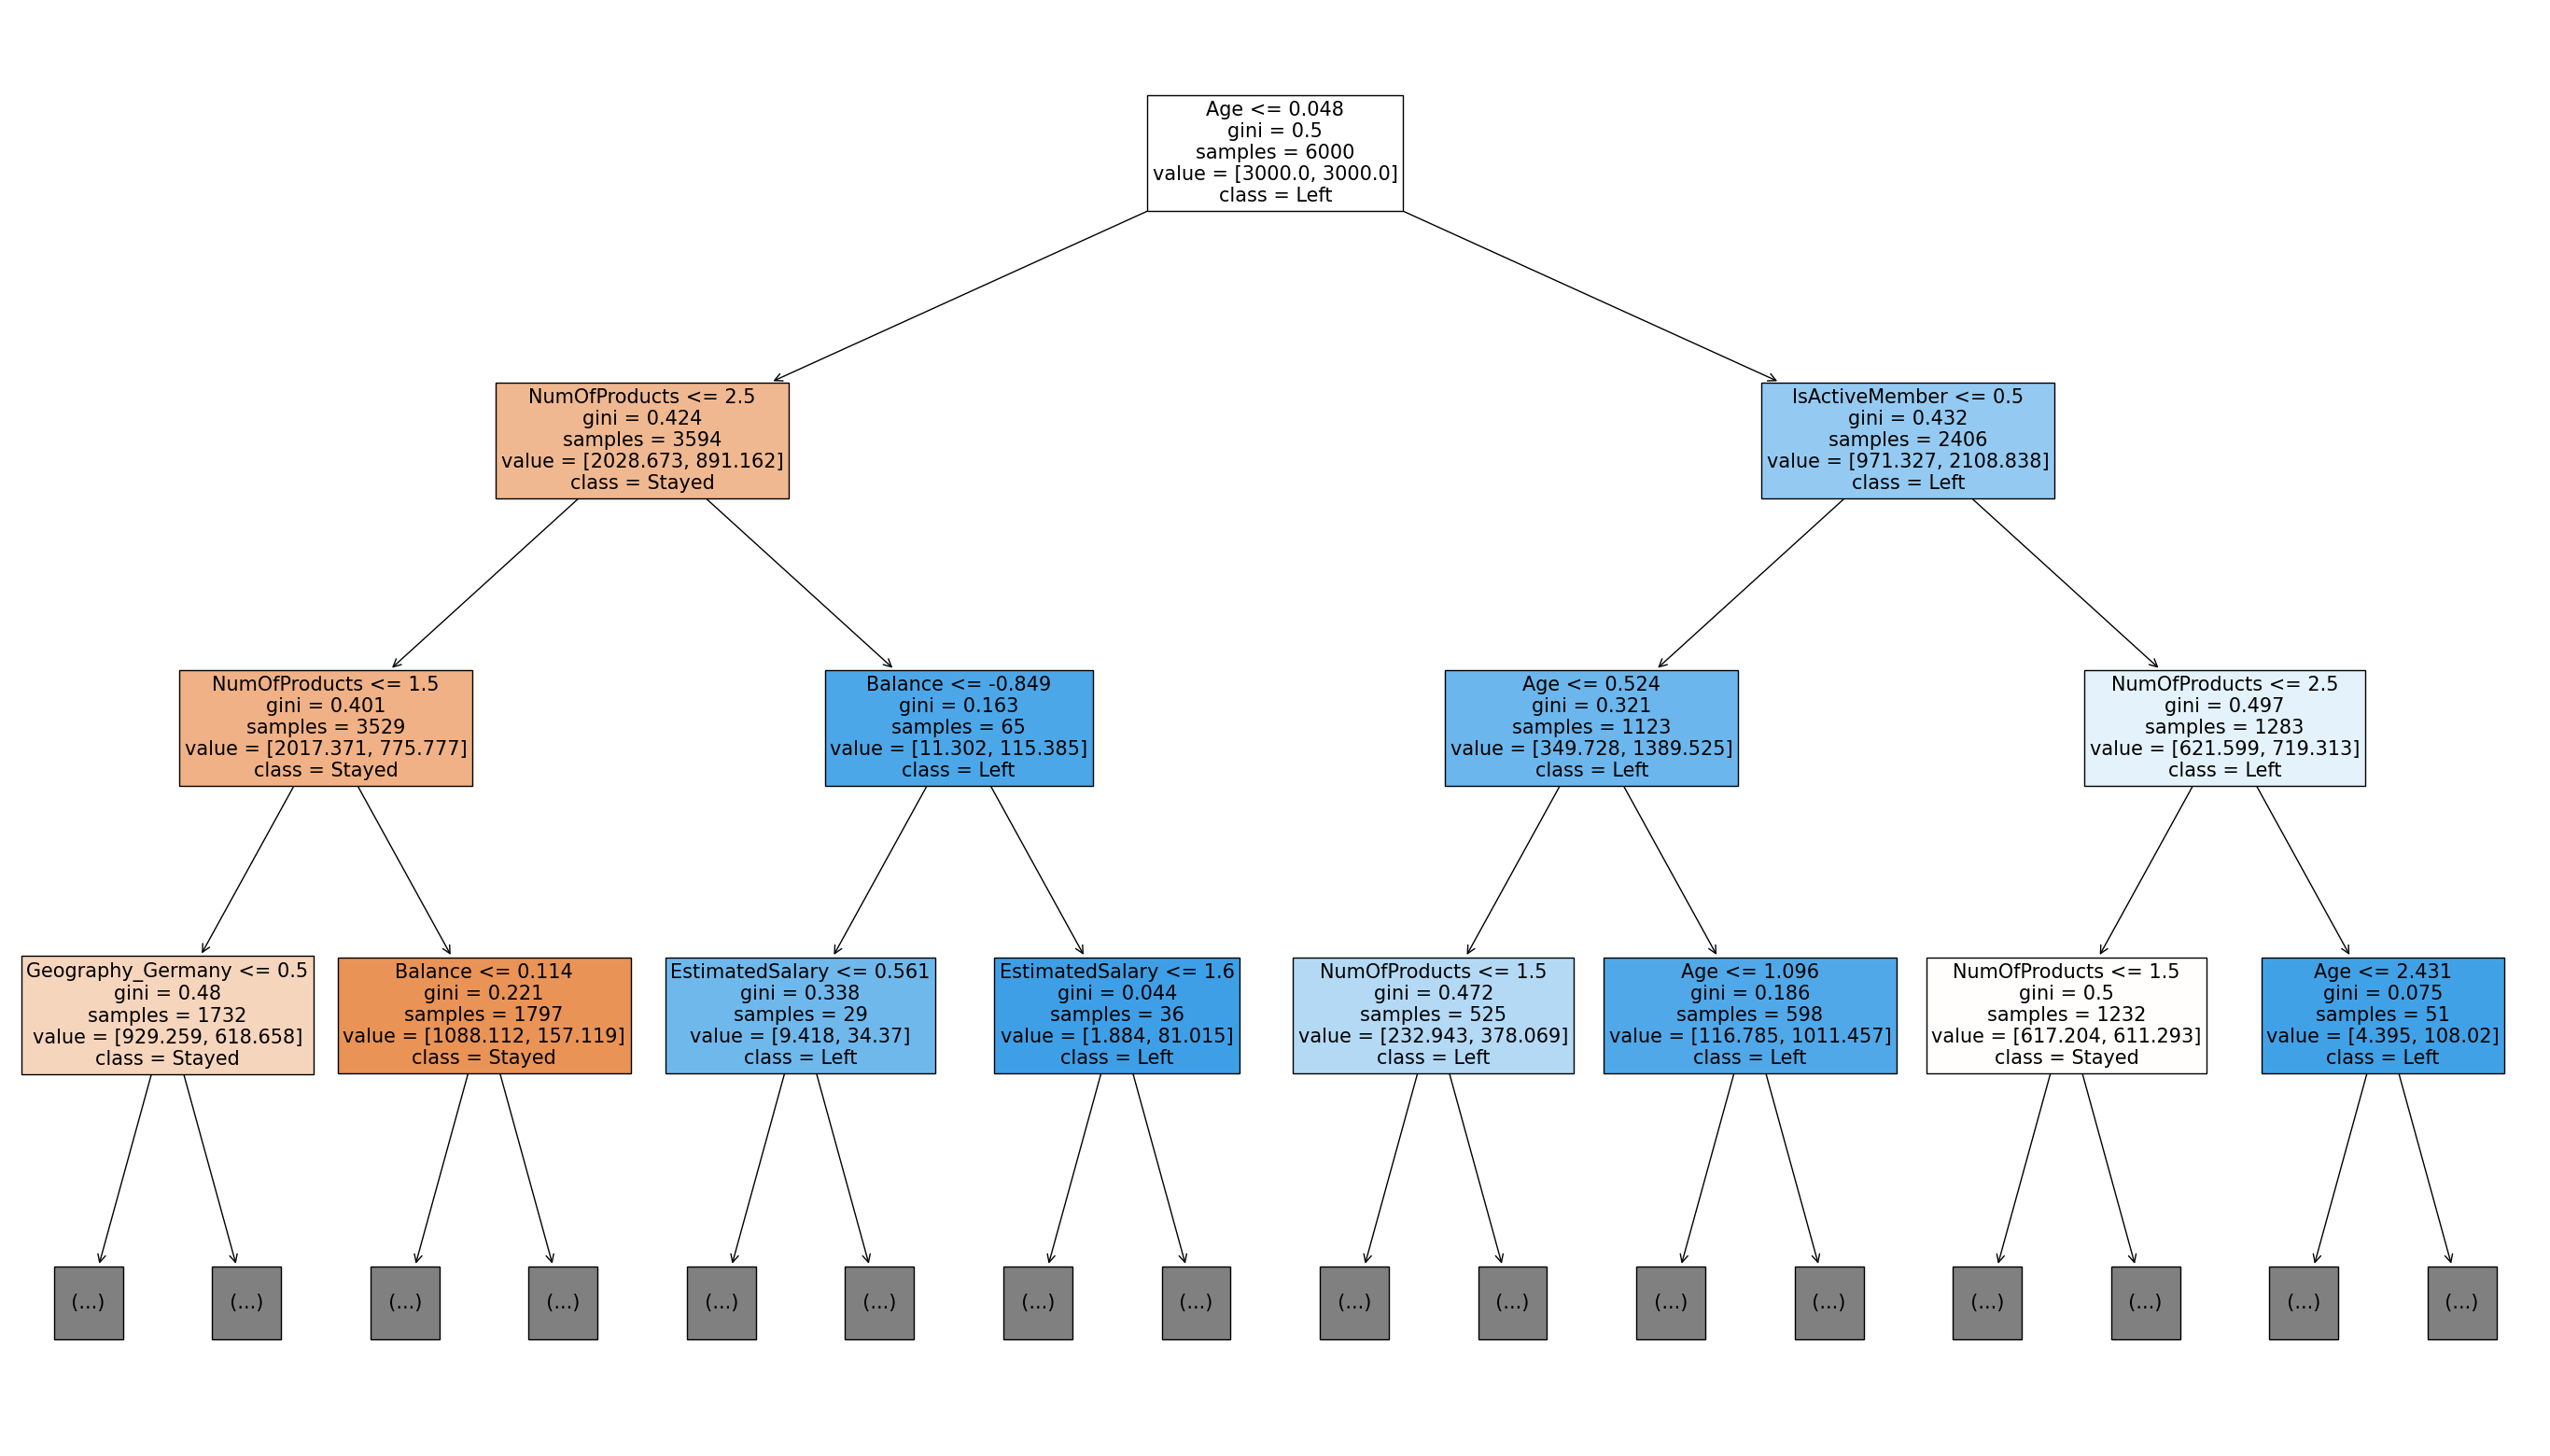

In [266]:
fig = plt.figure(figsize=(35,20))# график, который показывает, как модель делает предсказания
tree.plot_tree(best_model_tree_scaled,
                   feature_names=features.columns.values,
                   class_names=['Stayed','Left'],
                   filled=True,
                   fontsize = 15,
                   max_depth = 3
                   )
plt.show()

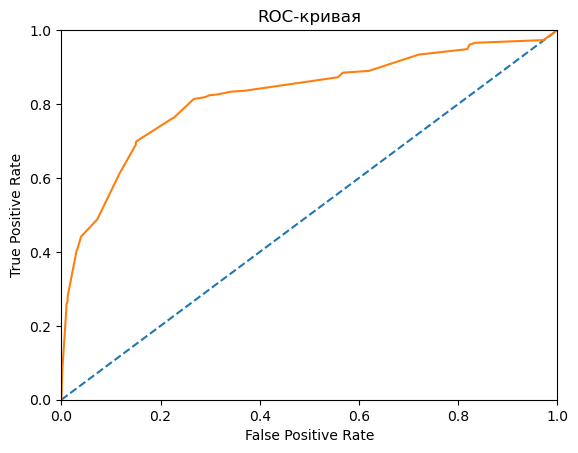

In [267]:
probabilities_valid = best_model_tree_scaled.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [268]:
roc_auc_score(target_valid, probabilities_one_valid)# метрика AUC-ROC

0.8219359665976944

 Качество модели понизилось по сравнению с результатами обучения без балансировки классов по всем метрикам

#### Случайный лес

In [269]:
%%time
best_model_forest_scaled = None# в переменной сохранится лучшая модель после проверки
best_f1 = 0
best_f1_train = 0
best_depth = 0
best_est = 0
f1_change_train = []
f1_change_valid = []
for est in range(10, 120, 4):
    for depth in range(1, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')# инициализируйте модель RandomForestClassifier с параметрами random_state=12345, n_estimators=est и max_depth=depth
        model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
        predictions_valid = model.predict(features_valid)# получаем предсказания модели на валидационной выборке
        predictions_train = model.predict(features_train)# получаем предсказания модели на тестовой выборке
        f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
        f1_train = f1_score(target_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
        f1_change_train.append(f1_train)
        f1_change_valid.append(f1_valid)
        if best_f1 < f1_valid:
            best_model_forest_scaled = model
            best_f1 = f1_valid
            best_f1_train = f1_train
            best_depth = depth
            best_est = est
print("F1 наилучшей модели на валидационной выборке:", best_f1,"F1 наилучшей модели на тестовой выборке:", best_f1_train,"Количество деревьев:", best_est, "Глубина дерева:", best_depth)

F1 наилучшей модели на валидационной выборке: 0.6586248492159228 F1 наилучшей модели на тестовой выборке: 0.80221957986524 Количество деревьев: 46 Глубина дерева: 10
Wall time: 2min 23s


Получилось улучшить качество модели по метрике F1 более чем на 3 процента благодаря балансировке классов

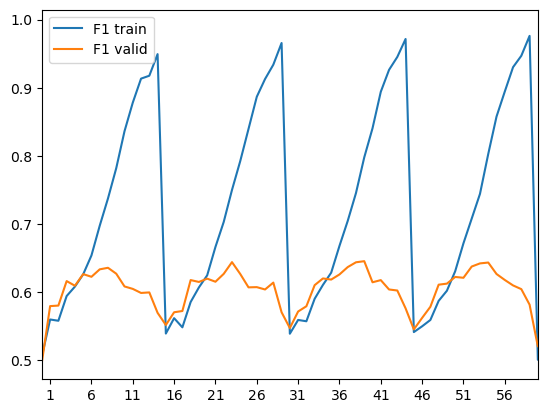

In [270]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины и количества деревьев
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 60])
plt.legend()
plt.show()

С балансировкой классов F1 на тренировочной показывает, что удалось избежать сильного переобучения

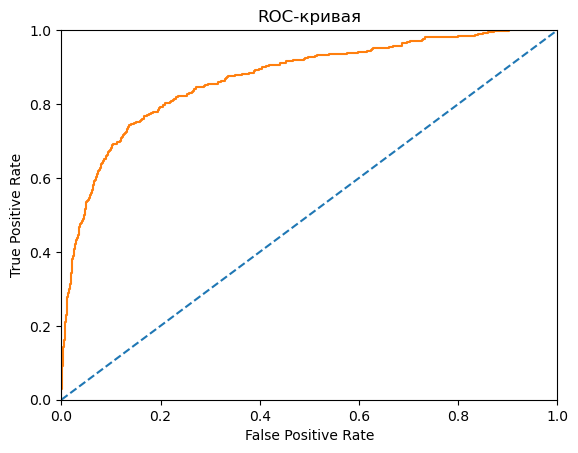

In [271]:
probabilities_valid = best_model_forest_scaled.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [272]:
roc_auc_score(target_valid, probabilities_one_valid)# метрика AUC-ROC

0.8692251083850626

Показатель метрики АUC-ROC тоже вырос, качество увеличилось

#### Логистическая регрессия


In [273]:
model_regression_scaled = LogisticRegression(random_state=12345, class_weight='balanced')# инициализируем модель LogisticRegression
model_regression_scaled.fit(features_train, target_train)
predictions_valid = model_regression.predict(features_valid)
predictions_train = model_regression.predict(features_train)
f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
f1_train = f1_score(target_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
print("F1 наилучшей модели на валидационной выборке:", f1_valid,"F1 наилучшей модели на обучающей выборке:", f1_train)

F1 наилучшей модели на валидационной выборке: 0.3107861060329068 F1 наилучшей модели на обучающей выборке: 0.3190332326283987


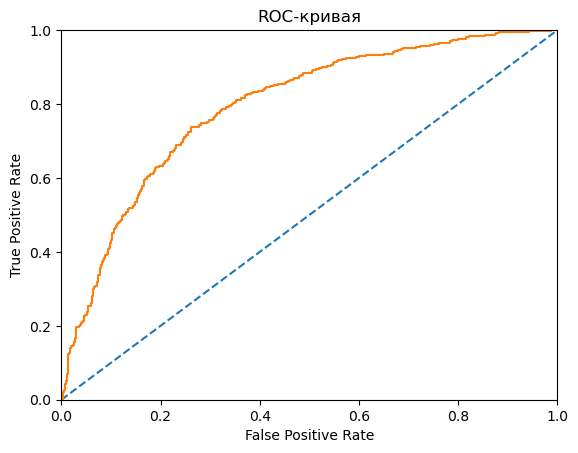

In [274]:
probabilities_valid = model_regression_scaled.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [275]:
roc_auc_score(target_valid, probabilities_one_valid)  # метрика AUC-ROC

0.7937142821952902

Модель логистической регрессии не показала улучшений

### Вес классов сбалансируем с помощью метода upsample


In [276]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Нужно увеличить выборку так, чтобы целевой признак "1" приравнялся к "0", в 4 раза

In [277]:
def upsample(features, target, repeat):# функция для балансировки признаков
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4)# балансируем признаки у тренировочной выборки

In [278]:
target_upsampled_train.value_counts()# проверяем размеры классов в тренировочной выборке после балансировки

1    4888
0    4778
Name: Exited, dtype: int64

#### Решающее дерево

In [279]:
%%time
best_model_tree_scaled_up = None# в переменной сохранится лучшая модель после проверки
best_f1 = 0
best_f1_train = 0
best_depth = 0
f1_change_train = []
f1_change_valid = []
for depth in range(1, 300):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)# инициализируем модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model.fit(features_upsampled_train, target_upsampled_train) # обучаем модель на тренировочной выборке
    predictions_valid = model.predict(features_valid)# получаем предсказания модели на валидационной выборке
    predictions_train = model.predict(features_upsampled_train)# получаем предсказания модели на тестовой выборке
    f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
    f1_train = f1_score(target_upsampled_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
    f1_change_train.append(f1_train)
    f1_change_valid.append(f1_valid)
    if best_f1 < f1_valid:
        best_model_tree_scaled_up = model
        best_f1 = f1_valid
        best_f1_train = f1_train
        best_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_f1,"F1 наилучшей модели на обучающей выборке:", best_f1_train,"Глубина дерева:", best_depth)

F1 наилучшей модели на валидационной выборке: 0.5769944341372912 F1 наилучшей модели на обучающей выборке: 0.7966033158107562 Глубина дерева: 6
Wall time: 12.4 s


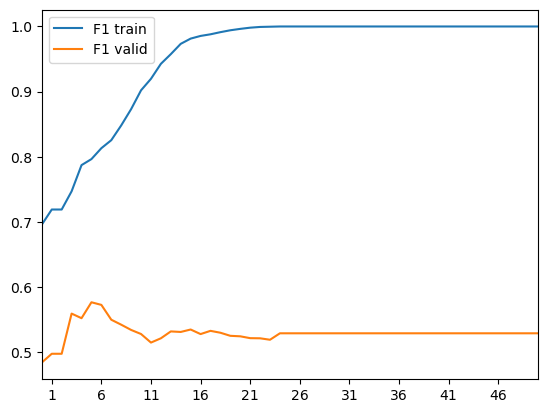

In [280]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 50])
plt.legend()
plt.show()

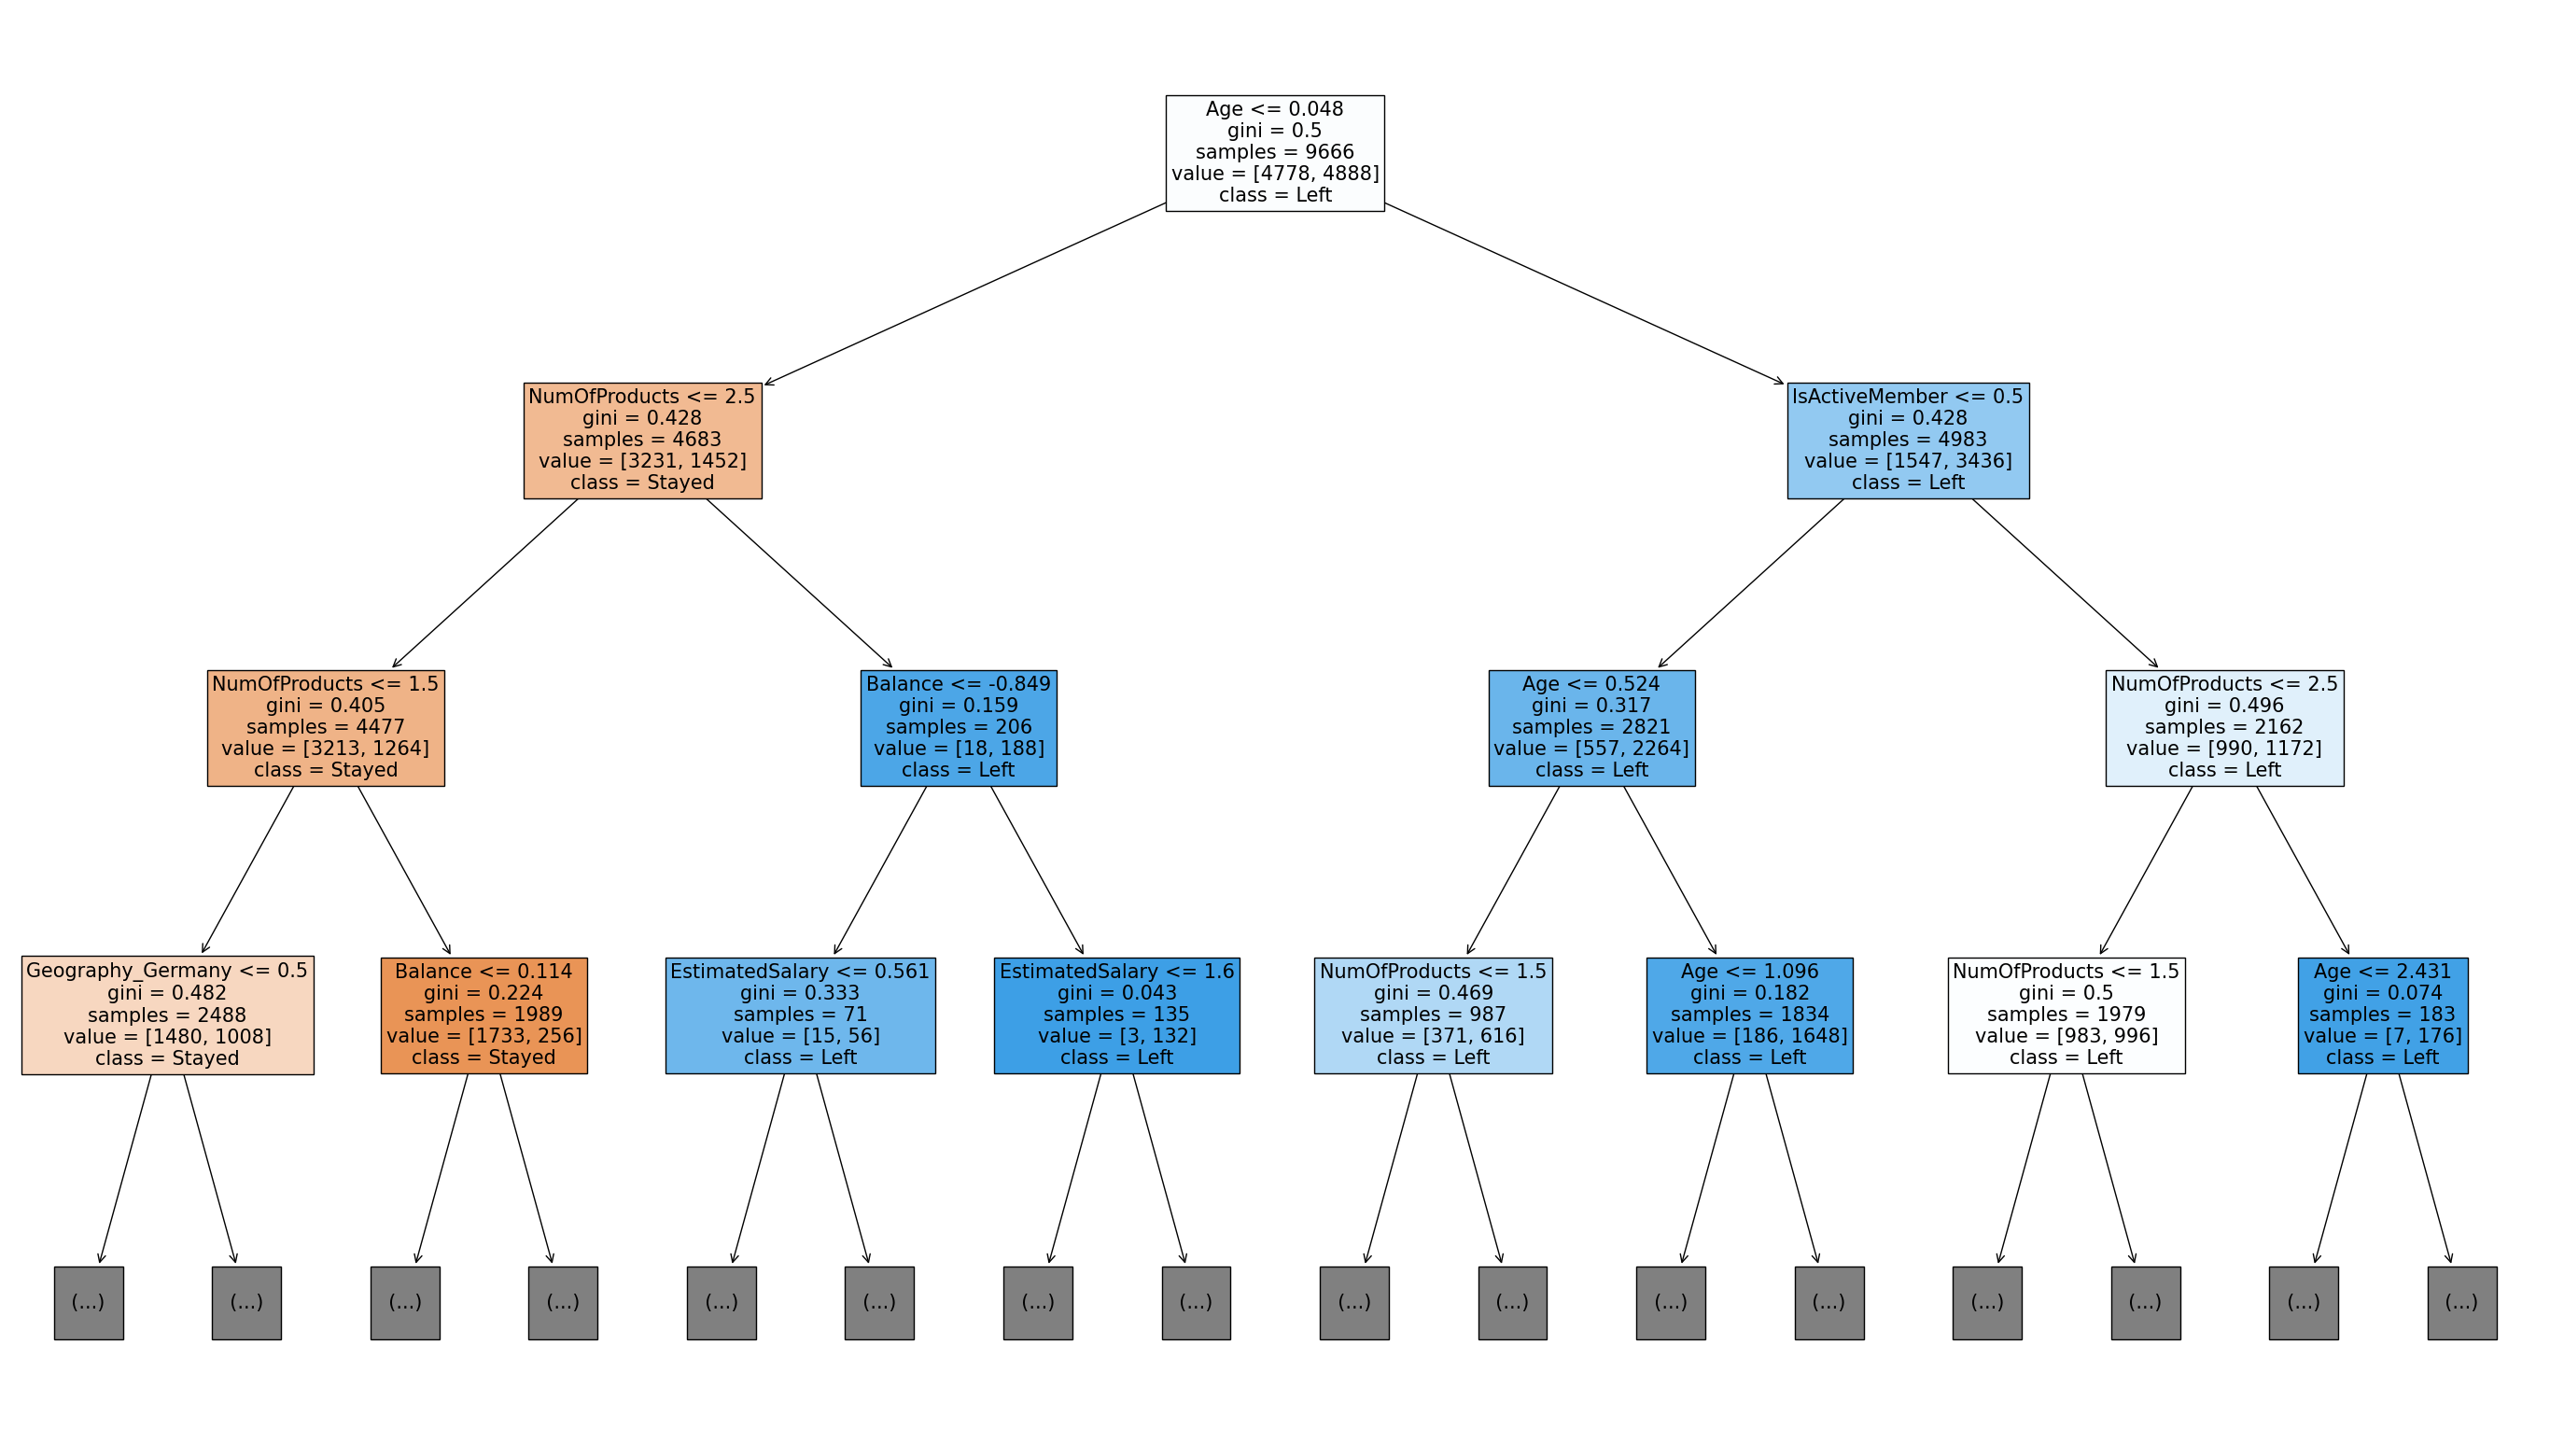

In [281]:
fig = plt.figure(figsize=(35,20))# график, который показывает, как модель делает предсказания
tree.plot_tree(best_model_tree_scaled_up,
                   feature_names=features.columns.values,
                   class_names=['Stayed','Left'],
                   filled=True,
                   fontsize = 15,
                   max_depth = 3
                   )
plt.show()

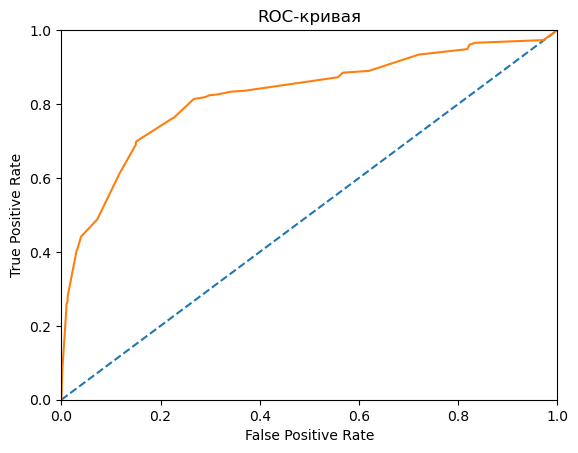

In [282]:
probabilities_valid = best_model_tree_scaled.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [283]:
roc_auc_score(target_valid, probabilities_one_valid)# метрика AUC-ROC

0.8219359665976944


У данной модели не получилось значительного улучшения показателя метрики F1


#### Случайный лес

In [284]:
%%time
best_model_forest_scaled_up = None# в переменной сохранится лучшая модель после проверки
best_f1 = 0
best_f1_train = 0
best_depth = 0
best_est = 0
f1_change_train = []
f1_change_valid = []
for est in range(10, 120, 4):
    for depth in range(1, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)# инициализируйте модель RandomForestClassifier с параметрами random_state=12345, n_estimators=est и max_depth=depth
        model.fit(features_upsampled_train, target_upsampled_train) # обучаем модель на тренировочной выборке
        predictions_valid = model.predict(features_valid)# получаем предсказания модели на валидационной выборке
        predictions_train = model.predict(features_upsampled_train)# получаем предсказания модели на тестовой выборке
        f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
        f1_train = f1_score(target_upsampled_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
        f1_change_train.append(f1_train)
        f1_change_valid.append(f1_valid)
        if best_f1 < f1_valid:
            best_model_forest_scaled_up = model
            best_f1 = f1_valid
            best_f1_train = f1_train
            best_depth = depth
            best_est = est
print("F1 наилучшей модели на валидационной выборке:", best_f1,"F1 наилучшей модели на тестовой выборке:", best_f1_train,"Количество деревьев:", best_est, "Глубина дерева:", best_depth)

F1 наилучшей модели на валидационной выборке: 0.6560364464692483 F1 наилучшей модели на тестовой выборке: 0.944114636642784 Количество деревьев: 42 Глубина дерева: 11
Wall time: 3min 23s


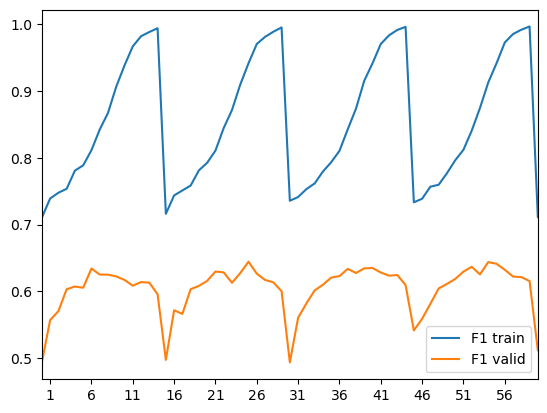

In [285]:
plt.plot(f1_change_train, label='F1 train')# строим график изменения метрики f1 в зависимости от глубины и количества деревьев
plt.plot(f1_change_valid, label='F1 valid')
plt.xticks(range(1,300,5))
plt.xlim([0, 60])
plt.legend()
plt.show()

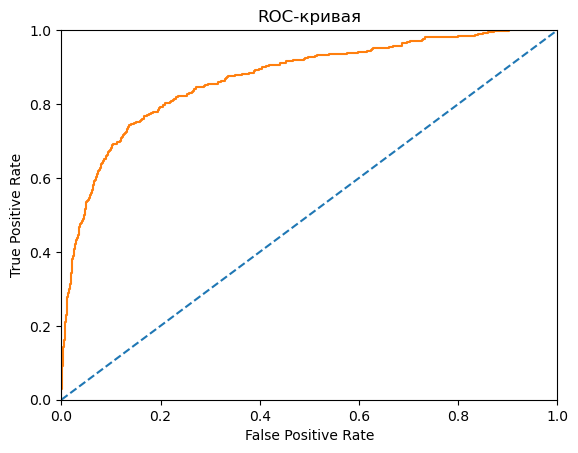

In [286]:
probabilities_valid = best_model_forest_scaled.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [287]:
roc_auc_score(target_valid, probabilities_one_valid)# метрика AUC-ROC

0.8692251083850626

У данной модели мы смогли добиться небольшого улучшения качества предсказаний, пока что текущая модель случайного леса является приоритетной

#### Логистическая регрессия

In [288]:
model_regression_scaled_up = LogisticRegression(random_state=12345)# инициализируем модель LogisticRegression
model_regression_scaled_up.fit(features_upsampled_train, target_upsampled_train)
predictions_valid = model_regression.predict(features_valid)
predictions_train = model_regression.predict(features_upsampled_train)
f1_valid = f1_score(target_valid, predictions_valid)# считаем значение метрики f1 на валидационной выборке
f1_train = f1_score(target_upsampled_train, predictions_train)# получаем значение метрики f1 на тестовой выборке
print("F1 наилучшей модели на валидационной выборке:", f1_valid,"F1 наилучшей модели на обучающей выборке:", f1_train)

F1 наилучшей модели на валидационной выборке: 0.3107861060329068 F1 наилучшей модели на обучающей выборке: 0.3454932111892688


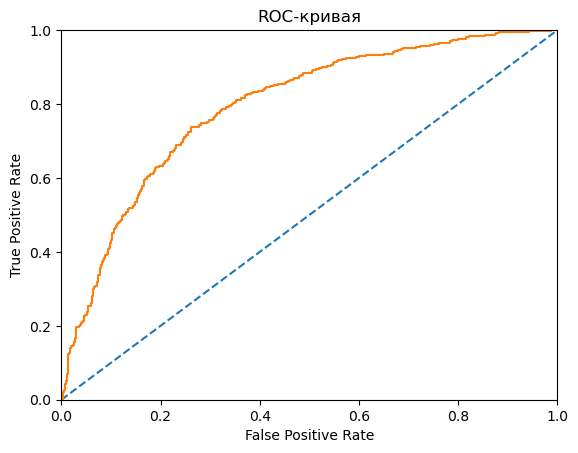

In [289]:
probabilities_valid = model_regression_scaled.predict_proba(features_valid)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [290]:
roc_auc_score(target_valid, probabilities_one_valid)  # метрика AUC-ROC

0.7937142821952902

Модель логистической регрессии показала незначительный прирост в качестве, но все равно остается худшей


Возьмем за основу модель случайного леса с балансировкой классов двумя методами и проведем тест на ней


## Шаг 4. Проверка лучшей модели на тестовой выборке

In [291]:
predictions_test = best_model_forest_scaled.predict(features_test) # получаем предсказания модели на тестовой выборке
f1_test = f1_score(target_test, predictions_test)# считаем значение точности на тестовой выборке
print("F1 наилучшей модели на тестовой выборке:", f1_test)

F1 наилучшей модели на тестовой выборке: 0.5911330049261083


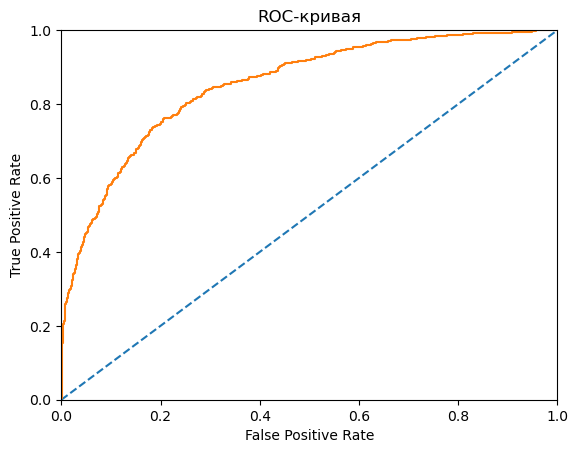

In [292]:
probabilities_valid = best_model_forest_scaled.predict_proba(features_test)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [293]:
roc_auc_score(target_test, probabilities_one_valid)

0.8525243271005982

Метрика AUC-ROC почти такая же, как и на валидационной выборке

In [294]:
predictions_test = best_model_forest_scaled_up.predict(features_test) # получаем предсказания модели на тестовой выборке
f1_test = f1_score(target_test, predictions_test)# считаем значение точности на тестовой выборке
print("F1 наилучшей модели на тестовой выборке:", f1_test)

F1 наилучшей модели на тестовой выборке: 0.5866050808314088


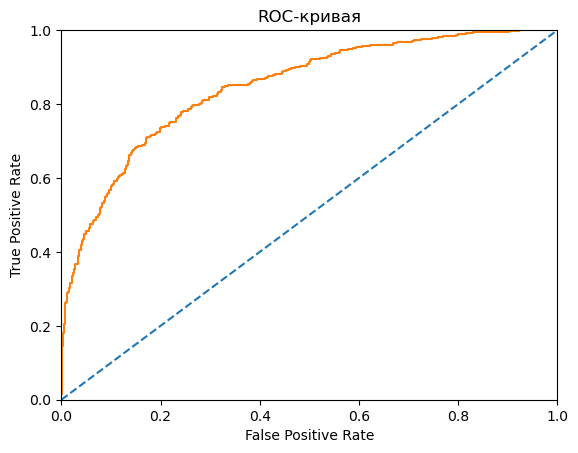

In [295]:
probabilities_valid = best_model_forest_scaled_up.predict_proba(features_test)# считаем вероятность классов целевого признака
probabilities_one_valid = probabilities_valid[:, 1]# выбираем только единицу
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)# вычисляем TPR и FPR
plt.figure()# строим график
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [296]:
roc_auc_score(target_test, probabilities_one_valid)

0.8465507109574906

У модели случайного леса, обученной на тренировочной выборке сбалансированной гиперпараметром class_weight, метрика F1 немного выше, выбираем ее.


## Шаг 6. Вывод


Для того чтобы обучить наилучшую модель с показателем F1 не менее 0.59 мной была проделана следующая работа:<br>
1. Общий обзор данных, собрал информацию о признаках для выборок<br>
2. Подготовил данные к обучению модели, разделил на тренировочную, валидационную и тренировочную выборки(без учета баланса классов)<br>
3. Подобрал параметры и обучил 3 различные модели - логистисческая регрессия, случайный лес и дерево решений, сравнил метрики качества предсказаний<br>
4. Провел повторное обучение моделей, но уже с учетом баланса классов - получилось улучшить качество предсказаний всех моделей и выбрать лучшую<br>
5. Провел финальный тест выбранной модели


***Для предсказаний целевого признака выберем модель с наилучшим результатом - случайный лес***<br>
Модель поможет банку предсказать, что клиент с высокой вероятностью перестанет пользоваться его услугами, этому клиенту можно будет предложить лучший тариф/скидку/другие условия по банковским продуктам, что будет более выгодным для банка, чем привлекать нового клиента.